# Abstract Syntax Trees, Grammars, Parsing

In [1]:
!apt-get -qq install -y graphviz
!pip install graphviz

In [0]:
# boilerplate code for importing Python modules
import sys
from types import *

try:
    import graphviz
except:
    print()
    print("*"*40)
    print("Error importing graphviz.")
    print("To install it on the VM, type:")
    print("      sudo pip3 install graphviz")
    print("and enter cmput274 as the password.")
    print()
    print("To install in Google Colaboratory, execute a block with these two commands:")
    print("      !apt-get -qq install -y graphviz")
    print("      !pip install graphviz")
    print("*"*40)
    print()
    sys.exit(0)

## Tree

A tree is an acyclic connected (undirect) graph. We think of a tree is being composed of subtrees, joined together at the root. A tree has a list of children.
If the list of children is empty, we say the tree is empty.

An empty tree t is constructed by
    `t = BasicTree()` 

If $t_0$, $t_1$, ..., $t_n$ are Trees, then 
    `t = BasicTree([`$t_0$, $t_1$, ..., $t_n$`])`
constructs a tree with the given subtrees as children.
Children are ordered, left to right, in same order as the list.

**Question**: During construction, Can $t_i$ and $t_j$ be the same tree?  

Maybe yes, maybe no, depending on how the tree is going to be used. If
it is immutable, then this structure sharing would be ok. If it can be
changed, then the children being passed must be "different" or
"independent".

In [3]:
%%file basictree.py
# file is a magic function for saving the content of a cell into a file

"""
BasicTree Class

A tree is an acyclic connected (undirect) graph
"""

class BasicTree:

    """
    BasicTree class

    BasicTree(children) - create a new instance of 
    the Tree class with given subtrees as children

    >>> t = BasicTree()
    >>> t._children == []
    True

    >>> cl = [ BasicTree(), BasicTree() ]
    >>> t = BasicTree(cl)
    >>> t.get_children() == cl
    True
    
    >>> t1 = BasicTree()
    >>> t1.set_children([1])
    Traceback (most recent call last):
    ...
    ValueError: Children in positions 0 are not of class <class '__main__.BasicTree'>

    >>> t2 = BasicTree([t1, 42])
    Traceback (most recent call last):
    ...
    ValueError: Children in positions 1 are not of class <class '__main__.BasicTree'>

    >>> t2 = BasicTree([[], t1, []])
    Traceback (most recent call last):
    ...
    ValueError: Children in positions 0,2 are not of class <class '__main__.BasicTree'>

    >>> t2 = BasicTree([t1, t1])
    Traceback (most recent call last):
    ...
    ValueError: Duplicate children in positions 1

    """

    def __init__(self, children=None):
        """
        This method is invoked when the Tree() constructor method
        is invoked to instantiate a new instance of class Tree.
        self is bound to the newly created bare object, 
        and __init__ initializes the initial state of the object.
        """

        if children is None:
            self._children = []
        else:
            self.check_children(children)
            self._children = children

            
    def check_children(self, children):
        """
        Check that children are roughly compliant with the assumption that
        they are instances of the class being constructed, and unique 
        identities.
        """

        bad_class_positions = []
        duplicate_positions = []

        already_used = set()
        for i, c in enumerate(children):

            # Is this child the same class as self?
            # Do we instead allow any subclass of self?
            if type(c) is not type(self):
                bad_class_positions.append(i)

            # And help guard against multiple cases of the same tree as a child.
            # Note: this is difficult to do in a reliable way, but a little
            # warning is better than nothing.
            if id(c) in already_used:
                duplicate_positions.append(i)
            else:
                already_used.add(id(c))

        if len(bad_class_positions) > 0:
            raise ValueError("Children in positions {} are not of class {}".
                format(",".join(map(str, bad_class_positions)), type(self)))

        if len(duplicate_positions) > 0:
            raise ValueError("Duplicate children in positions {}".
                format(",".join(map(str, duplicate_positions))))

        return True

    
    def get_children(self):
        """
        Return the children list of the tree - not a copy!
        """
        return self._children

    
    def set_children(self, children):
        """
        Set the children list of the tree to the new list, releasing
        the old list of children.
        """
        self.check_children(children)
        self._children = children
        
        
    def get_value(self):
        return str(id(self))
        

      
if __name__ == "__main__":
    import doctest
    doctest.testmod()

Overwriting basictree.py


In [0]:
%run basictree.py

In [0]:
def get_dot_format(dot, root):
    """
    Converts an instance of our BasicTree class to an instance of the graphviz 
    class Graph, which can then be displayed in a cell via

    graphviz.Source(return_value)

    Assumes each vertex of g can be converted to a string via str().
    """
    
    dot.node(str(root), root.get_value())
    children = root.get_children()
    for child in children:
        dot.edge(str(root), str(child))
      
        # recursive call
        get_dot_format(dot, child)

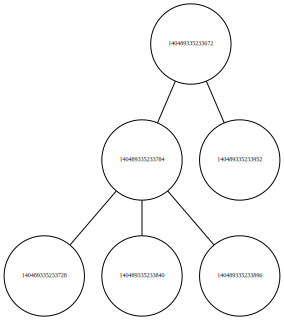

In [6]:
c1 = [ BasicTree(), BasicTree(), BasicTree() ]
c2 = BasicTree(c1)
c3 = BasicTree([])
t  = BasicTree([c2, c3])

dot = graphviz.Graph()
dot.attr('node', shape='circle')
dot.attr('node', fontsize='6')
get_dot_format(dot, t)
graphviz.Source(dot)

In [7]:
%%file valuetree.py


from basictree import *


"""
ValueTree Class

Extension of BasicTree to have a value associated with each node of the tree.
"""

class ValueTree(BasicTree):

    """
    ValueTree class

    A ValueTree is an attributed BasicTree. 
    Each node of the tree has an associated value.

    ValueTree(v) - constructs a new instance, 
    with value v and no children. It is a leaf.

    If each of t0, t1, ..., tn is-a ValueTree, then 
        t = ValueTree(v, [t0, t1, ..., tn] )
    constructs a new tree with value v, and children t0, t1, ..., tn.
    """

    def __init__(self, value=None, children=None):
        # The parent (super) class needs to be initialized.  
        # It will check the children for consistency.
        super().__init__(children)

        # Set the value of the node
        self._value = value

    
    def get_value(self):
        return self._value

      
    def set_value(self, v):
        self._value = v
        
        
    # Extract the shape as a list of lists
    def tree_to_valshape(self):
        """

        A valshape (value shape) is a representation of the the tree that
        describes both the shape and value attributes of the tree.

        Base case:  If t = ValueTree(v), then 
            t.tree_to_valshape() is the tuple (v, [])

        Inductive construction: If c = [t_0, ..., t_n] are ValueTree, and 
        t = ValueTree(v, c), then
            t.tree_to_valshape() is the tuple (v, [ vs_0, ..., vs_n ]) 
            where vs_i is the valshape of child t_i.
            
        >>> t = ValueTree(1, [ValueTree(2, [ValueTree(3), ValueTree(4)]), ValueTree(5)])
        >>> t.tree_to_valshape()
        (1, [(2, [(3, []), (4, [])]), (5, [])])

        Note that if the values in the tree have string representations,
        then value shapes can be used to save and load value trees on
        string-based storage.
        

        """
        return (self.get_value(), 
            [ c.tree_to_valshape() for c in self.get_children() ] )


    @classmethod
    def valshape_to_tree(cls, r):
        """

        Suppose t is a ValueTree, with valshape vs = t.tree_to_valshape(), 
        then 
            t_new = ValueTree.valshape_to_tree(vs)
        is a new ValueTree with the same shape and attributes as t.

        Works for any class cls derived from ValueTree

        >>> s = (42, [])
        >>> s == ValueTree.valshape_to_tree(s).tree_to_valshape() 
        True

        >>> s = (1, [(2, []),(3, [ (4, []), (5, [ (6, []),(7, []), (8, []) ])])])
        >>> s == ValueTree.valshape_to_tree(s).tree_to_valshape() 
        True

        >>> t_orig = ValueTree.valshape_to_tree(s)
        >>> t_copy = t_orig.valshape_to_tree(t_orig.tree_to_valshape())
        >>> t_copy.tree_to_valshape() == s
        True

        """

        (v, l) = r

        # List of children we are assembling for this node, we construct
        # trees of class cls.
        children = []
        for e in l:
            if type(e) is tuple:
                # if element is a list, construct the child tree
                children.append(cls.valshape_to_tree(e))
            else:
                raise ValueError("Element '{}' not in (value, childre)".format(e))

        # Make a node with these children, the children paramater may
        # be in different position for the cls() constructor, so specify it.
        return cls(value = v, children = children)


    def __str__(self):
        return str(self.get_value())
      
      
if __name__ == "__main__":
    import doctest
    doctest.testmod()

Overwriting valuetree.py


In [0]:
%run valuetree.py

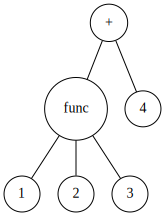

In [9]:
c1 = [ ValueTree('1', []), ValueTree('2', []), ValueTree('3', []) ]
c2 = ValueTree('func', c1)
c3 = ValueTree('4', [])
t  = ValueTree('+', [c2, c3])

dot = graphviz.Graph()
dot.attr('node', shape='circle')
get_dot_format(dot, t)
graphviz.Source(dot)

In [10]:
print(t.tree_to_valshape())

('+', [('func', [('1', []), ('2', []), ('3', [])]), ('4', [])])


In [0]:
"""
ExprTree Class

General Expression Tree

"""

class ExprTree(ValueTree):

    """
    Expression tree.

    An expression tree is a ValueTree where the values in the tree 
    are interpreted as follows:

    leaf nodes - have a value that is a constant object 
    (e.g., number, string, etc.)

    internal nodes - have a value that is a function object, 
    which takes the evaluated values of the children as its arguments.
    
    Hence, an expression tree can be evaluated.

    For example:
    >>> t = ExprTree( lambda x, y: x + y, [ ExprTree(3), ExprTree(4) ] )
    >>> t.evaluate()
    7

    """

    def __init__(self, value=None, children=None):

        # The parent (super) class needs to be initialized.  It will
        # check the children for consistency
        super().__init__(value, children)


    # Expression-related operations
    def evaluate(self, var_dict=None):

        if var_dict is None:
            var_dict = {}

        cl = self.get_children()
        if len(cl) == 0:
            return self.get_value()
        
        # recursive call
        args = [ c.evaluate(var_dict) for c in cl ]

        oper = self.get_value()

        # Special cases of set and get a variable 
        if oper == 'set':
            name = cl[0].get_value()
            value = cl[1].evaluate(var_dict)
            var_dict[name] = value
            return value

        if oper == 'get':
            name = cl[0].get_value()
            if name not in var_dict:
                raise ValueError("Variable '{}' has no value yet".format(name))
            value = var_dict.get(name)
            return value
        

        # *-operator is used to unpack the elements of args
        # if f(x, y, z) takes three arguments, and args = [1, 3, 5]
        # then f(*args) is the same as f(1, 3, 5)
        return oper(*args)
      
      
    def __str__(self):
        val = self.get_value()
        if type(val) == FunctionType:
            return str(val.__name__)
        else:
            return str(val)


if __name__ == "__main__":
    import doctest
    doctest.testmod()

In [14]:
c  = ExprTree( 'set', [ ExprTree('x'), ExprTree(4) ] )
t  = ExprTree( lambda x, y: x + y, [ ExprTree(3), 
                                     ExprTree('get', [ExprTree('x'), c]) ] )

print(t.evaluate())
print(t.tree_to_valshape())

7
(<function <lambda> at 0x7fc638e68400>, [(3, []), ('get', [('x', []), ('set', [('x', []), (4, [])])])])


## PLY 
PLY is a pure-Python implementation of the popular compiler construction tools `lex` and `yacc`.
The `lex` module is used to break input text into a collection of tokens specified by a collection of regular expression rules. The `yacc` module is used to recognize language syntax that has been specified in the form of a context free grammar.

In [0]:
class ValueParser():
    """
    Base class of parsers that return ValueTrees as abstract syntax trees,
    also called ASTs, or parse trees.

    A parser object is composed of a lexer component and a yacc component.
    The lexer component converts the input string into lexical tokens.  
    The yacc component parses a stream of lexical tokens into a ValueTree
    representation of the AST.

    In general, an AST is just an attributed tree, which will usually
    require further processing to produce executable code (for the
    various meanings of "executable code"). Since a given parse tree can
    be used to generate various artifacts, that "code generation" step
    does not belong in this class hierarchy.

    The particular details of the grammar are given in the derived class, 
    which contains the grammar (in ply format)

    We are using ply as the parser generator, developed by David Beazley
    and many collaborators. See: http://www.dabeaz.com/ply/

    But any tool with a lex and yacc style of interface would work,
    including a pythone wrapper for the traditional C-based lex/yacc,
    flex/bison, or multu-lingual ANTLR etc. generators.

    Each parser has a parse method and a possibly unimplemented unparse method.

    """

    def __init__(self, lexer, yacc, error_stack):
        """
        The derived class constructs the lexer and parser, 
        creates the error_stack in its __init__, 
        and then passes them to the base class __init__
        """

        self.lexer = lexer
        self.yacc = yacc
        self.error_stack = error_stack

    def parse(self, input_str):
        """
        Parse input_str, return a tuple (error_stack, ast)
        representing the status of the parse, and the associated parse_tree

        status - a list of strings representing the errors detected in parsing,
            stacked in order of generation.
        parse_tree - a ValueTree representing the abstract syntax tree (AST)
            resulting from the parse.

        The status of the parse is:
            [] - meaning that no problems were encountered, and parse_tree
                is complete
            non empty [] - meaning that some kind of problems were encountered 
                and status contains a list of diagnostic strings.
                
        """

        # Get rid of old error messages
        self.error_stack.clear()

        # now parse.
        ast = self.yacc.parse(input_str, lexer=self.lexer)
        return (self.error_stack, ast)

    def unparse(self, ast):
        """
        Convert the ast back into a string, which when re-parsed
        results in the same parse tree.  The result need not be, and in
        general will not be, the same string as the original input.

        In general it hard to unparse in the absence of knowledge of the
        original grammar, so the derived class has to implement this, if
        at all.

        Unparsing is one way to save the result of a parse for later
        re-generation.  Saving the parse tree as a value shape is another.
        """

        raise ValueError("No unparse method provided for {}".format(type(self)))

        
if __name__ == "__main__":
    import doctest
    doctest.testmod()        

In [16]:
%%file calc.py

import ply.lex as lex

# All possible token names that can be produced by the lexer
# This list is also used by the yacc to identify terminals
tokens = (
   'NUMBER',
   'PLUS',
   'MINUS',
   'TIMES',
   'DIVIDE',
   'LPAREN',
   'RPAREN',
)

# Regular expression rules for simple tokens
# Use raw strings to treat backslashes as literal characters
t_PLUS    = r'\+'
t_MINUS   = r'-'
t_TIMES   = r'\*'
t_DIVIDE  = r'/'
t_LPAREN  = r'\('
t_RPAREN  = r'\)'

# The name following the `t_` must exactly match 
# one of the names supplied in tokens



# If some kind of action needs to be performed, 
# a token rule can be specified as a function

# A regular expression rule with some action code
def t_NUMBER(t):
    r'\d+'
    # this rule matches numbers and converts the string into a Python integer
    # When tokens are returned by lex, 
    # they have a value that is stored in the value attribute
    t.value = int(t.value)    
    return t
  
# Define a token rule that returns no value
def t_COMMENT(t):
    r'\#.*'
    pass
    # No return value. Token discarded
    
# A string containing ignored characters (spaces and tabs)
t_ignore  = ' \t'

# Define a rule so we can track line numbers
def t_newline(t):
    r'\n+'
    t.lexer.lineno += len(t.value)

# Handle lexing errors that occur when illegal characters are detected
def t_error(t):
    print("Illegal character '%s'" % t.value[0])
    t.lexer.skip(1)

# Build the lexer
# lex is used to tokenize an input string
lexer = lex.lex()

Overwriting calc.py


In [0]:
%run calc.py

In [18]:
# Test it out
data = '''
3 + 4 * 10
  + -20 *2
'''

# Give the lexer some input
lexer.input(data)

# Tokenize
for tok in lexer:
    # The tokens returned by lexer are instances of LexToken
    print(tok)
    # print(tok.type, tok.value, tok.lineno, tok.lexpos)

LexToken(NUMBER,3,2,1)
LexToken(PLUS,'+',2,3)
LexToken(NUMBER,4,2,5)
LexToken(TIMES,'*',2,7)
LexToken(NUMBER,10,2,9)
LexToken(PLUS,'+',3,14)
LexToken(MINUS,'-',3,16)
LexToken(NUMBER,20,3,17)
LexToken(TIMES,'*',3,20)
LexToken(NUMBER,2,3,21)


## A Context Free Grammar for Arithmetic Expressions
__Grammar__

`S' -> statement`

`statement -> expression`

`statement -> <empty>`
  
`expression -> NAME = expression`

`expression -> expression + expression`

`expression -> expression - expression`

`expression -> expression * expression`

`expression -> expression / expression`

`expression -> - expression`

`expression -> NAME LPAREN RPAREN`

`expression -> NAME LPAREN expr_list RPAREN`

`expression -> LPAREN expression RPAREN`

`expr_list -> expression`

`expr_list -> expr_list COMMA expression`

`expression -> NUMBER`

`expression -> NAME`


In [19]:
%%file calclex.py

from valuetree import *
import ply.lex as lex
import ply.yacc as yacc

# Literals

# A literal character is simply a single character that is returned "as is" 
# when encountered by the lexer
literals = ['=', '+', '-', '*', '/', ]

# Tokens

# All possible token names that can be produced by the lexer
# This list is also used by the yacc to identify terminals
tokens = [ 'NAME', 'NUMBER', 'COMMA', 'LPAREN', 'RPAREN' ] 


# Each token is specified by writing a regular expression rule compatible with Python's re module
# Use raw strings to treat backslashes as literal characters
t_NAME = r'[a-zA-Z_][a-zA-Z0-9_]*'
t_COMMA = r','
t_LPAREN = r'\('
t_RPAREN = r'\)'


def t_NUMBER(t):
    r'\d+'
    t.value = int(t.value)
    return t

t_ignore = " \t"


def t_newline(t):
    r'\n+'
    t.lexer.lineno += t.value.count("\n")


def t_error(t):
    error_stack.append("Illegal character '{}'".format(t.value[0]))
    t.lexer.skip(1)
    
    
# Parsing rules

precedence = (
    ('left', '+', '-'),
    ('left', '*', '/'),
    ('right', 'UMINUS'),
)



# Grammar rules

# Node types for the AST, if you change these, also update in __init__ 
N_APPLY = 'apply'
N_SET = 'set'
N_GET = 'get'
N_CONST = 'const'
N_PASS = 'pass'

# p_statement is the root of the resulting AST
# The values of p[i] are mapped to grammar symbols
def p_statement_expr(p):
    'statement : expression'
    #    ^            ^
    #   p[0]         p[1]
    p[0] = p[1]


def p_statement_empty(p):
    "statement : "
    #   ^
    #  p[0]
    p[0] = ValueTree(N_PASS)


def p_expression_assign(p):
    'expression : NAME "=" expression'
    #   ^          ^    ^       ^
    #  p[0]       p[1] p[2]    p[3]
    p[0] = ValueTree(N_SET, [ ValueTree(p[1]), p[3] ])


def p_expression_binop(p):
    '''expression : expression '+' expression
                  | expression '-' expression
                  | expression '*' expression
                  | expression '/' expression'''
    #     ^             ^       ^       ^
    #    p[0]          p[1]    p[2]    p[3]
    p[0] = ValueTree(N_APPLY, [ ValueTree(p[2]), p[1], p[3] ])


def p_expression_uminus(p):
    "expression : '-' expression %prec UMINUS"
    #     ^        ^       ^
    #    p[0]     p[1]    p[2]
    p[0] = ValueTree(N_APPLY, [ValueTree("neg"), p[2] ])


def p_fn_apply_0(p):
    "expression : NAME LPAREN RPAREN"
    #     ^        ^      ^      ^
    #    p[0]     p[1]   p[2]   p[3]
    p[0] = ValueTree(N_APPLY, [ ValueTree(p[1]) ])


def p_fn_apply(p):
    "expression : NAME LPAREN expr_list RPAREN"
    #     ^        ^      ^       ^        ^
    #    p[0]     p[1]   p[2]    p[3]     p[4]
    p[0] = ValueTree(N_APPLY, [ ValueTree(p[1]) ] + p[3] )


def p_expression_group(p):
    "expression : LPAREN expression RPAREN"
    #     ^        ^         ^        ^
    #    p[0]     p[1]      p[2]     p[3]
    p[0] = p[2]


# Assemble elements of list, but delay ValueTree construction
# until finishing the list.

def p_expr_list_1(p):
    'expr_list : expression'
    #     ^          ^        
    #    p[0]       p[1]
    p[0] = [ p[1] ]


def p_expr_list_2(p):
    'expr_list : expr_list COMMA expression'
    #     ^        ^         ^        ^
    #    p[0]     p[1]      p[2]     p[3]
    if p[1] is None:
        p[0] = p[3]
    else:
        p[0] = p[1] + [ p[3] ]


def p_expression_number(p):
    "expression : NUMBER"
    #     ^         ^        
    #    p[0]      p[1]
    p[0] = ValueTree(N_CONST, [ValueTree(p[1])])


def p_expression_name(p):
    "expression : NAME"
    #     ^        ^        
    #    p[0]     p[1]
    p[0] = ValueTree(N_GET, [ValueTree(p[1])])

def p_error(p):
    if p:
        error_stack.append("Syntax error at '{}'".format(p.value))
    else:
        error_stack.append("Syntax error at EOF")

# Global error stack, on which we place results of calls to t_error, p_error
# If the stack is empty, the parse should be OK.
error_stack = []

# Build the lexer which is used to tokenize input
lexer = lex.lex()

# Build the parser which is used to parse language syntax
yacc = yacc.yacc()

Overwriting calclex.py


In [0]:
%run calclex.py

In [21]:
# Test it out
data = '''
x = 1
3 + x * 10
  + -20 *2
'''

# Give the lexer some input
lexer.input(data)

# Tokenize
for tok in lexer:
#     print(tok.type, tok.value, tok.lineno, tok.lexpos)
    print(tok)

LexToken(NAME,'x',2,1)
LexToken(=,'=',2,3)
LexToken(NUMBER,1,2,5)
LexToken(NUMBER,3,3,7)
LexToken(+,'+',3,9)
LexToken(NAME,'x',3,11)
LexToken(*,'*',3,13)
LexToken(NUMBER,10,3,15)
LexToken(+,'+',4,20)
LexToken(-,'-',4,22)
LexToken(NUMBER,20,4,23)
LexToken(*,'*',4,26)
LexToken(NUMBER,2,4,27)


In [0]:
class ExprParser(ValueParser):
    """
    Expression parser class. Returns a ValueTree representing the
    abstract syntax tree resulting from the parse. Each node in the ast
    with value ntype, and associated children, is interpeted as follows:

        const: [ value ] 
            - construct and return the constant value 

        set:  [ dest, src ] 
            - bind name dest to value src

        get: [ src ] 
            - fetch the value bound to name src

        apply: [ fn, args, ... ] 
            - apply the function fn to the arguments args 
            - not that things in the grammar, like binary ops +, *
            are also represented this way.

    """

    def __init__(self, lexer, yacc):
        """
        Parser object for simple expression language.

        In addition to the base class instance variables, this defines
        the following tables used to map symbols in the input grammar
        into 
        """
        # Note that we have to set up the references to the lexer and yacc 
        # parser here because the grammar is defined in this file scope.


        # Link up the error stack
        this_error_stack = error_stack
        
        super().__init__(lexer, yacc, this_error_stack)

        # Node types for the AST, map from the name used in the
        # construction step of the rule, to the string that appears as
        # a value in the ValueTree that results from the parse.

        self.node_types = {
            'N_APPLY' : 'apply',
            'N_SET' : 'set',
            'N_GET' : 'get',
            'N_CONST' : 'const',
            'N_PASS' : 'pass',
            }


    def parse(self, input_str):
        # Invoke the initial parser in the base class.  

        (errors, ast) = super().parse(input_str)

        return (errors, ast)


    def unparse(self, t):
        """
        Unparse the AST that we have generated.
        """
        
        children = t.get_children()
        n = len(children)
        s = ""
        if n == 0:
            return str(t.get_value())

        op = self.fn_to_op.get(t.get_value()) 

        binary_op = (n == 2) and (op is not None)

        if op is None:
            # if no actual function, use the value in the expression tree
            op = t.get_value()

        # Special case for binary operations
        if binary_op:
            return "({} {} {})".format(
                self.unparse(children[0]), 
                op,
                self.unparse(children[1]))

        return "{}({})".format(op, 
            ",".join([self.unparse(c) for c in children]))

In [29]:
p = ExprParser(lexer, yacc)
(e, t) = p.parse("x = (1 + y) * 3 + f(4, 5)")
print(t.tree_to_valshape())

StructViz.update_viz(t, "t-ast", style='compact', pause=0, format=['png'])

('set', [('x', []), ('apply', [('+', []), ('apply', [('*', []), ('apply', [('+', []), ('const', [(1, [])]), ('get', [('y', [])])]), ('const', [(3, [])])]), ('apply', [('f', []), ('const', [(4, [])]), ('const', [(5, [])])])])])


<img src="http://webdocs.cs.ualberta.ca/~oardakan/files/t-ast.dot.png">

## Calculator

In [25]:
"""
Simple expression-based calculator, with variables.  
The expression language is pecisely defined by the ExprParser class. 
But in general it is the usual arithmetic formulas, with the additional
ability to bind variable names to values, 
and use the value a variable is bound to.
"""

# Debugging and comprehension settings
debug = True

class Calculator():
    """
    A Calculator is a service for evaluating sequences of strings that
    represent formulas.  The formulas are evaluated in a context that
    provides a binding from variables to values, and formulas can change
    the context for later use.
    """

    def __init__(self, lexer, yacc):
        """
        Build an expression parser to get the AST for the input string

        This will generate, if not present and up-to-date, the parse 
        tables: 
            parser.out, parsetab.py
        in the current directory.
        """

        self.parser = ExprParser(lexer, yacc)
        
        self.ast = None


    # Tables mapping operators in the AST to corresponding functions during
    # evaluation, and vice-versa.
    op_to_fn = {
        'neg': (lambda x: -x),
        '+': (lambda x, y: x + y),
        '-': (lambda x, y: x - y),
        '*': (lambda x, y: x * y),
        'sqr': (lambda x: x * x),
        '?': None,
        }

    fn_to_op = dict([(v, k) for k, v in op_to_fn.items()])

    def evaluate(self, expr_str, var_dict=None):
        """
        Evaluate the expression given by expr_str, using and updating the
        context defined by the variable dictionary var_dict.

        Inputs:
            expr_str - a string in the expression language
            var_dict - a dictionary that maps variable names to values

        Outputs:
            returns the value of the expression, or throws an exception
                containing parsing or evaluation errors.

            var_dict - updates the variable dictionary.  If an expression
                is partially evaluated and has modified variables in 
                var_dict, then if an error is encountered, the modifications
                will remain.

        """

        # Evaluation proceeds in two steps.  First parse the string into
        # and AST, represented by a ValueTree.  
        # Then traverse the AST evaluating it as an expression.

        try:
            (errors, ast) = self.parser.parse(expr_str)
            self.ast = ast
        except Exception as e:
            raise ValueError( "Parseing internal error: {}".format(e))

        if len(errors) > 0:
            raise ValueError( "Parsing generated errors:\n{}".format(
                    "\n".join(errors)))

        if ast is None:
            return None

        if var_dict is None:
            var_dict = {}

        if debug:
            print(ast.tree_to_valshape())            

        return self.evaluate_ast(ast, var_dict)


    def evaluate_ast(self, ast, var_dict):
        """
        Traverse the AST, represented by a ValueTree, and evaulate it,
        using the appropriate functions as defined by op_to_fn.

        Examples:
            1 + 2
        =>
            ('apply', [('+', []), ('const', [(1, [])]), ('const', [(2, [])])])

        
            y = x + 1
        =>
            ('set', [('y', []), ('apply', [('+', []), 
                ('get', [('x', [])]), ('const', [(1, [])])])]

            (x = 2) + 1
        =>
            ('apply', [('+', []), ('set', [('x', []), 
                ('const', [(2, [])])]), ('const', [(1, [])])])

        """

        ntype = ast.get_value()
        children = ast.get_children()

        if ntype == 'const':
            return children[0].get_value()

        if ntype == 'apply':
            op = children[0].get_value()
            fn = self.op_to_fn.get(op)

            if fn is None:
                raise ValueError(
                    "Evaluation error, no implementation of operation '{}'".
                    format(op))

            args = [ self.evaluate_ast(c, var_dict) for c in children[1:] ]
            return fn(*args)
        
        if ntype == 'set':
            # bind name to value
            name = children[0].get_value()
            value = self.evaluate_ast(children[1], var_dict)
            var_dict[name] = value
            return value

        if ntype == 'get':
            # get value bound to name
            name = children[0].get_value()
            if name not in var_dict:
                raise ValueError(
                    "Evaluation error, variable '{}' has no value yet".
                    format(name))

            value = var_dict.get(name)
            return value

        # anything else
        raise ValueError(
            "Evaluation internal error, AST node type '{}' not implemented".
            format(ntype))
        
    def get_ast(self):
        return self.ast


def main():
    # Persistent map of names to their current value
    var_dict = {}

    calc = Calculator(lexer, yacc)

    # Ask for an expression until get EOF or blank line.
    while True:
        print("?", end='', flush=True)
        # return empty string on EOF
        s = input().strip()
        if s == "": 
            # Quit on blank line or EOF
            break

        result = None
        try:
            result = calc.evaluate(s, var_dict)
        except Exception as e:
            print("Error: {}".format(e))

        print(result)
        # Back for more

    print("Done")

    
if __name__ == "__main__":
    main()

?2 + 5
('apply', [('+', []), ('const', [(2, [])]), ('const', [(5, [])])])
7
?x = 10
('set', [('x', []), ('const', [(10, [])])])
10
?x = x - 1
('set', [('x', []), ('apply', [('-', []), ('get', [('x', [])]), ('const', [(1, [])])])])
9
?y = sqr(x) + 3
('set', [('y', []), ('apply', [('+', []), ('apply', [('sqr', []), ('get', [('x', [])])]), ('const', [(3, [])])])])
84
?
Done
